# Parallel Computing

Parallel computing is a programming method that **harnesses the power of multiple processors (or cores) at once**. Once of concern only to programmers of large supercomputers, modern computers now almost always have multi-core processors. However:

> At the heart of efficient parallel code is fast serial code!!

### How many CPU cores do I have?

In [3]:
using Hwloc
Hwloc.num_physical_cores()

4

(Note that `Sys.CPU_THREADS` may or may not be equal to the number above. It indicates the number of CPUs + Hyperthreads.)

### Why go parallel?

<img src="imgs/42-years-processor-trend.svg" width=700px>

### **Amdahl's Law**

Naive expectation: I have 4 cores, give me my 4x speedup!

>If $p$ is the fraction of a code that can be parallelized than the maximal theoretical speedup by parallelizing on $n$ cores is given by $F(n) = 1/(1-p + p/n)$.

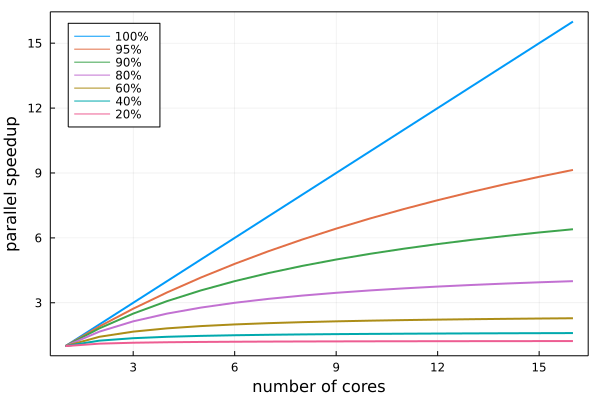

In [4]:
using Plots
F(p,n) = 1/(1-p + p/n)

pl = plot()
for p in reverse(sort(vcat(0.2:0.2:1, [0.9, 0.95])))
    plot!(pl, n -> F(p,n), 1:16, lab="$(Int(p*100))%", lw=2,
        legend=:topleft, xlab="number of cores", ylab="parallel speedup", frame=:box)
end
pl

# Parallel Computing in Julia

Julia documentation link: [Parallel computing](https://docs.julialang.org/en/v1/manual/parallel-computing/index.html)

There are many types of parallelism, some of which are (from micro to macro)

* **Instruction level parallelism**
* **Multi-threading** (process shared memory)
* **Multi-Core processing** (maybe system shared memory)
* **Distributed processing** (same as above but involving multiple machines)

Julia provides (more or less) native support for all of these forms of parallel processing (same order as above)

* `@simd` and [SIMD.jl](https://github.com/eschnett/SIMD.jl)
* `@threads, @spawn` (introduced in 2015)
* `@spawnat`, `@fetch`, `RemoteChannel`, `SharedArray`, etc.
* `@spawnat`, `@fetch`, `RemoteChannel`, `DistributedArray`, `MPI.jl` etc.

With scientific computing in mind, we will mainly focus on how to distribute a process through multiple cores or machines (our thp cluster for example), that is **Multi-Core processing** and **Distributed processing**. But before we can do so, we have to learn how to control Julia's control flow through tasks.

# Tasks (Control flow)

By default, Julia waits for every command to finish and run everything sequentially.

Tasks are a control flow feature that allows computations to be **suspended** and resumed in a flexible manner. This feature is sometimes called by other names, such as coroutines, green or lightweight threads and cooperative multitasking.

To me, the name **cooperative multitasking** is the most descriptive. Tasks are managed/scheduled by Julia and can sometimes be run in a quasi-parallel fashion.

An important use case is **asynchronous I/O**, which is typically slow. Examples are
 * **multiple user input** (Why not already process some of the input?)
 * **data dumping to disk** (Maybe it's possible to continue a calculation?)
 * **receiving calculations from worker processes** (We'll need that below!)

How do we execute commands asynchronously?

## `@async` and `@sync`

(Based on [this](https://stackoverflow.com/questions/37287020/how-and-when-to-use-async-and-sync-in-julia/37287021#37287021) stackoverflow answer.)

In [5]:
?@async

```
@async
```

Wrap an expression in a [`Task`](@ref) and add it to the local machine's scheduler queue.

Values can be interpolated into `@async` via `$`, which copies the value directly into the constructed underlying closure. This allows you to insert the *value* of a variable, isolating the asynchronous code from changes to the variable's value in the current task.

!!! compat "Julia 1.4"
    Interpolating values via `$` is available as of Julia 1.4.



What this means is that for whatever falls within its scope, Julia will start a task to then proceed to whatever comes next in the script **without waiting for the task to complete**.

In [6]:
@time sleep(2);

  2.001134 seconds (66 allocations: 1.688 KiB)


In [7]:
@time @async sleep(2)

  0.010775 seconds (6.35 k allocations: 379.981 KiB, 92.33% compilation time)


Task (runnable) @0x00007fba21649b60

Julia allows the script to proceed (and the `@time` macro to fully execute) without waiting for the task (in this case, sleeping for two seconds) to complete.

We can use the `@sync` macro to synchronize, that is wait for, all encapsulated tasks. (see `?@sync`). 

In [8]:
@time @sync @async sleep(2)

  2.019456 seconds (824 allocations: 49.609 KiB, 0.90% compilation time)


Task (done) @0x00007fb979c4a6e0

Of course, here it doesn't make much sense to write `@sync @async` - we could simply drop it altogether.

A better example is the following.

In [9]:
@time @sync begin
    @async sleep(2.0)
    @async sleep(2.0)
end

  2.008897 seconds (1.12 k allocations: 70.578 KiB, 0.36% compilation time)


Task (done) @0x00007fb979c4b0f0

In [10]:
@sync begin
    @async (sleep(2); println("Today is reverse day!"))
    @async (sleep(1); println(" class!"))
    @async print("Hello")
end;

Hello class!
Today is reverse day!


# Distributed processing: Multi-core

Distributed computing in Julia means having **multiple separate Julia instances running on different cores** on the same or different machines.

Data movement and communication between processes is explicit.

Let's focus on the *multi-core* case (your laptop/desktop) and save some cluster fun for later.

## Master-worker model

Julia uses a *master-worker* paradigm for its native distributed parallelism.

One master process coordinates all the worker processes, which perform the actual computations.

By default, Julia starts with one process on one core. If this single process is all we have, than it is both the master and the worker.

In [11]:
using Distributed # Loading all tools that we need for distributed computing

In [12]:
nprocs()

1

In [13]:
nworkers() # the master is considered a worker as long as there are no real workers

1

To increase the number of workers, i.e. Julia processes, from within a Julia session we can use `addprocs`.

Alternatively, when starting Julia from the command line, one can use the `-p` option. Example,

```
julia -p 4
```

will start Julia with 5 processes, 1 master and 4 workers.

In [14]:
addprocs(4) # I have 4 cores, so let's add 4 worker processes.

4-element Vector{Int64}:
 2
 3
 4
 5

Every process has a Julia internal `pid` (process id). The master is always 1. You can get the workers pids from `workers()`.

In [15]:
workers()

4-element Vector{Int64}:
 2
 3
 4
 5

Note that the 4 worker's pids aren't necessarily 2, 3, 4 and 5. Let's remove the processes and add them once more.

In [16]:
rmprocs(workers()) # rmprocs(array of pids of worker processes to remove)

Task (done) @0x00007fb97840f3d0

In [17]:
nworkers() # only the master is left

1

In [18]:
addprocs(4)

4-element Vector{Int64}:
 6
 7
 8
 9

In [19]:
workers()

4-element Vector{Int64}:
 6
 7
 8
 9

## One master to rule them all - `@spawn`, `@spawnat`, `@fetch`, `@fetchfrom`, `@everywhere`...

To execute commands and start computations on workers we can use the following macros

* `@spawn`: run a command or a code block on any worker and return a `Future` to it's result. It's basically a version of `@async` for remote processes.
* `@spawnat`: same as `@spawn` but one can choose a specific worker by providing its pid.

**Example:** Let's say we would like to generate a random matrix on one of the workers.

In [20]:
@spawn rand(2,2) # basically @async for remote process, i.e. returns immediately

Future(6, 1, 10, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), nothing)

In [21]:
result = @spawn rand(2,2)

Future(7, 1, 11, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0), nothing)

In [22]:
fetch(result) # blocks, like @sync

2×2 Matrix{Float64}:
 0.873892   0.549974
 0.0523779  0.528236

Because the combination of spawning at fetching is so common, there is `@fetch` which combines them.

In [23]:
@fetch rand(2,2)

2×2 Matrix{Float64}:
 0.614739  0.90331
 0.241076  0.752674

Which worker did the work?

In [26]:
@fetch begin
    println(myid());
    rand(2,2)
end

      From worker 7:	7


2×2 Matrix{Float64}:
 0.362803  0.631745
 0.384787  0.388226

Using `@spawnat` and `@fetchfrom` we can delegate the work to a specific worker.

In [27]:
@fetchfrom 7 begin
    println(myid());
    rand(2,2)
end

      From worker 7:	7


2×2 Matrix{Float64}:
 0.868491  0.784499
 0.368557  0.833647

We can use `@sync` as a blocker to wait for all workers to complete their tasks.

In [28]:
@sync begin
    pids = workers()
    @spawnat pids[1] (sleep(2); println("Today is reverse day!"))
    @spawnat pids[2] (sleep(1); println(" class!"))
    @spawnat pids[3] println("Hello")
end;
println("Done!")

      From worker 8:	Hello
      From worker 7:	 class!
      From worker 6:	Today is reverse day!
Done!


Ok, now that we understood all that, let's delegate a *complicated* calculation

In [30]:
using Random

function complicated_calculation()
    sleep(1) # so complex that it takes a long time :)
    randexp(5)
end

@fetch complicated_calculation()

LoadError: On worker 9:
UndefVarError: #complicated_calculation not defined
Stacktrace:
  [1] [0m[1mdeserialize_datatype[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:1332[24m[39m
  [2] [0m[1mhandle_deserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:854[24m[39m
  [3] [0m[1mdeserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:801[24m[39m
  [4] [0m[1mhandle_deserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:861[24m[39m
  [5] [0m[1mdeserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:801[24m[39m[90m [inlined][39m
  [6] [0m[1mdeserialize_global_from_main[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Distributed/src/[39m[90m[4mclusterserialize.jl:160[24m[39m
  [7] [0m[1m#5[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Distributed/src/[39m[90m[4mclusterserialize.jl:72[24m[39m[90m [inlined][39m
  [8] [0m[1mforeach[22m
[90m    @ [39m[90m./[39m[90m[4mabstractarray.jl:2712[24m[39m
  [9] [0m[1mdeserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Distributed/src/[39m[90m[4mclusterserialize.jl:72[24m[39m
 [10] [0m[1mhandle_deserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:947[24m[39m
 [11] [0m[1mdeserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:801[24m[39m
 [12] [0m[1mhandle_deserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:858[24m[39m
 [13] [0m[1mdeserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:801[24m[39m
 [14] [0m[1mhandle_deserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:861[24m[39m
 [15] [0m[1mdeserialize[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Serialization/src/[39m[90m[4mSerialization.jl:801[24m[39m[90m [inlined][39m
 [16] [0m[1mdeserialize_msg[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Distributed/src/[39m[90m[4mmessages.jl:87[24m[39m
 [17] [0m[1m#invokelatest#2[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:716[24m[39m[90m [inlined][39m
 [18] [0m[1minvokelatest[22m
[90m    @ [39m[90m./[39m[90m[4messentials.jl:714[24m[39m[90m [inlined][39m
 [19] [0m[1mmessage_handler_loop[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Distributed/src/[39m[90m[4mprocess_messages.jl:169[24m[39m
 [20] [0m[1mprocess_tcp_streams[22m
[90m    @ [39m[90m/opt/julia-1.7.3/share/julia/stdlib/v1.7/Distributed/src/[39m[90m[4mprocess_messages.jl:126[24m[39m
 [21] [0m[1m#103[22m
[90m    @ [39m[90m./[39m[90m[4mtask.jl:429[24m[39m

What happened?

**Think of every worker as a separate Julia instance.**

We only defined `complicated_calculation()` on the master process. The function doesn't exist on any of the workers yet.

The macro `@everywhere` comes for the rescue.

In [31]:
@everywhere begin # execute this block on all workers
    using Random
    
    function complicated_calculation()
        sleep(1)
        randexp(5) # lives in Random
    end
end

In [32]:
@fetch complicated_calculation()

5-element Vector{Float64}:
 0.38745762810154094
 3.153131732886896
 0.26071378350653146
 1.3529543484048359
 1.148318031667005

## Data movement

There is a crucial difference between the following two pieces of code. Can you guess what it is?

In [33]:
function method1()
    A = rand(100,100)
    B = rand(100,100)
    C = @fetch A^2 * B^2
end

method1 (generic function with 1 method)

In [34]:
function method2()
    C = @fetch rand(100,100)^2 * rand(100,100)^2
end

method2 (generic function with 1 method)

Let's benchmark them.

In [35]:
using BenchmarkTools
@btime method1();
@btime method2();

  347.738 μs (90 allocations: 237.80 KiB)
  294.214 μs (68 allocations: 80.94 KiB)


Method 1 is slower, because `A` and `B` are created on the master process, transferred to a worker, and squared and multiplied on the worker process before the result is finally transferred back to the master.

Method 2, on the other hand, creates, squares, and multiplies the random matrix all on the work process and only submits the result to the master.

Hence, `method1` is **transferring 3x as much data** between the master and the worker!

**Data movement is crucial!**

In this toy example, it's rather easy to identify the faster method.

In a real program, however, understanding data movement does require more thought and likely some measurement.

For example, if the first process needs matrix `A` in a follow-up computation then the first method might be better in this case. Or, if computing `A` is expensive and only the current process has it, then moving it to another process might be unavoidable.

#### Computer latency at a human scale

To understand why thinking about data is important it's instructive to look at the time scales involved in data access.

<img src="imgs/latency_human_scales.png" width=900px>

(taken from https://www.prowesscorp.com/computer-latency-at-a-human-scale/)

### Avoid globals (once more)

In [36]:
myglobal = 4

4

In [37]:
function whohas(s::String)
    @everywhere begin
        var = Symbol($s)
        if isdefined(Main, var)
            println("$var exists.")
        else
            println("Doesn't exist.")
        end
    end
    nothing
end

whohas (generic function with 1 method)

In [38]:
whohas("myglobal")

myglobal exists.
      From worker 8:	Doesn't exist.
      From worker 7:	Doesn't exist.
      From worker 6:	Doesn't exist.
      From worker 9:	Doesn't exist.


In [39]:
@fetchfrom 6 myglobal+2

6

In [40]:
whohas("myglobal")

myglobal exists.
      From worker 7:	Doesn't exist.
      From worker 6:	myglobal exists.
      From worker 9:	Doesn't exist.
      From worker 8:	Doesn't exist.


Globals get copied to workers and continue to exist as globals even after the call.

This could lead to memory accumulation if many globals are used (just as it would in a single Julia session).

It's better to avoid them.

Note that there exist tools for **explicit data transfer** beyond what we discuss here: see [`Channel`s and `RemoteChannel`s](https://docs.julialang.org/en/v1/manual/distributed-computing/#Channels-and-RemoteChannels) as well as [ParallelDataTransfer.jl](https://github.com/ChrisRackauckas/ParallelDataTransfer.jl/).

# Parallelizing the easy way - `@distributed` and `pmap`

So far we have seen the build block of commands for distributed computing in Julia. Having scientific computing in mind, one might not always want to think about how to distribute the work and explicitly spawn tasks.

Also, fortunately, many useful parallel computations do not require (much) data movement. A common example is a direct Monte Carlo simulation, where multiple processes can handle independent simulation trials simultaneously. (We'll get to that later!)

Julia provides convenience macros to
 * Parallelize loops (`@distributed`)
 * Apply a function to all elements in some collection (`pmap`)
 
Let's explore these!

## Distributed loops (`@distributed`)

In [41]:
using Distributed, BenchmarkTools; rmprocs(workers()); addprocs(4); nworkers()

4

In [42]:
# serial version - count heads in a series of coin tosses
function add_serial(n)
    c = 0
    for i = 1:n
        c += rand(Bool)
    end
    c
end

@btime add_serial(200_000_000);

  264.686 ms (0 allocations: 0 bytes)


This is trivially parallelizable since the loop iterations are independent of each other. We can distribute coin tosses over a couple of workers.

Afterwards we combine the results, that is we sum them up. The combination process is generally called a *reduction*, and in this case `sum` is the *reducer function*.

To distribute the for loop over worker processes Julia provides the `@distributed` macro:

In [43]:
?@distributed

```
@distributed
```

A distributed memory, parallel for loop of the form :

```
@distributed [reducer] for var = range
    body
end
```

The specified range is partitioned and locally executed across all workers. In case an optional reducer function is specified, `@distributed` performs local reductions on each worker with a final reduction on the calling process.

Note that without a reducer function, `@distributed` executes asynchronously, i.e. it spawns independent tasks on all available workers and returns immediately without waiting for completion. To wait for completion, prefix the call with [`@sync`](@ref), like :

```
@sync @distributed for var = range
    body
end
```


In [44]:
# distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        Int(rand(Bool))
    end
    c
end

@btime add_distributed(200_000_000);

  69.952 ms (285 allocations: 12.19 KiB)


The distributed version is about **4x faster**, which is all we could hope for.

Let's see who is doing the work

In [45]:
# verbose distributed version
function add_distributed(n)
    c = @distributed (+) for i in 1:n
        x = Int(rand(Bool))
        println(x);
        x
    end
    c
end

add_distributed(8);

      From worker 10:	0
      From worker 10:	0
      From worker 12:	1
      From worker 12:	0
      From worker 11:	0
      From worker 11:	0
      From worker 13:	0
      From worker 13:	0


Apparently, the work is evenly distributed between the workers. By using `@distributed` we let Julia decide how to split up the work and can't control it ourselves.

A common mistake when using `@distributed` is the following:

In [46]:
function f(n)
    a = 0
    @distributed (+) for i in 1:n
        a += 1
    end
    a
end

a = f(10);

What do you expect the value of `a` to be?

In [47]:
a

0

We can (sort of) see what's happening by making everything global

In [48]:
a = 0
@distributed (+) for i in 1:10
    println("1")
    global a += 1
end;

      From worker 13:	1
      From worker 13:	1
      From worker 12:	1
      From worker 12:	1
      From worker 11:	1
      From worker 11:	1
      From worker 10:	1
      From worker 10:	1
      From worker 10:	1
      From worker 11:	1


In [49]:
@everywhere @show a

a = 0
      From worker 12:	a = 2
      From worker 13:	a = 2
      From worker 10:	a = 3
      From worker 11:	a = 3


The variable `a` gets copied to the worker processes as it is referenced in the distributed loop. 

Every worker will then increment its copy of `a`.

However, we do not save the result of the reduction (sum) but instead return `a` from the master process, which hasn't been altered at all.

Corrected version:

In [50]:
function f2(n)
    a = @distributed (+) for i in 1:n
        1
    end
    a
end

a = f2(10)

10

### What if I don't want to reduce?

Similar to the mistake above, the following example might not have the effect one expects. **Why?**

In [51]:
a = zeros(10)
@distributed for i = 1:10
    a[i] = i
end

Task (runnable) @0x00007fb9be6a4b90

In [52]:
@everywhere @show a

a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
      From worker 11:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 8.0, 0.0, 0.0]
      From worker 10:	a = [0.0, 0.0, 0.0, 4.0, 5.0, 6.0, 0.0, 0.0, 0.0, 0.0]
      From worker 12:	a = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 10.0]
      From worker 13:	a = [1.0, 2.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


Note that `@distributed` without a reduction function returns a `Task`. It is basically a distributed version of `@spawn` for all the iterations.

## `SharedArray`s

To actually make all processes operate on the same array, one can use a `SharedArray`.

Note that a `SharedArray` only works if the **processes live on the same host**.

The constructor of a SharedArray is

```julia
SharedArray{T,N}(dims::NTuple; init=false, pids=Int[])
```

which creates an `N`-dimensional shared array of a (bits) type `T` and size `dims` across the processes specified by `pids`.

(If an `init` function, of signature `initfn(S::SharedArray)`, is specified, it is called on all the participating workers. You can specify that each worker runs the init function on a distinct portion of the array, thereby parallelizing initialization.)

In [53]:
@everywhere using SharedArrays # must be loaded everywhere

In [54]:
A = rand(2,3)

2×3 Matrix{Float64}:
 0.814917  0.399215   0.757549
 0.327237  0.0101991  0.463634

In [55]:
S = SharedArray(A)

2×3 SharedMatrix{Float64}:
 0.814917  0.399215   0.757549
 0.327237  0.0101991  0.463634

Ok, now that we know how to create and fill our `SharedArray` we can create a parallel fill function:

In [56]:
function fill_shared_problematic(N)
    S = SharedMatrix{Float64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

fill_shared_problematic(3)

3×3 SharedMatrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

*Why is the method in its current form problematic? Try to find out yourself by going to larger `N` and, for example, inspecting the minimum of the returned `SharedArray`!*

Going to larger matrix sizes....

In [57]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

0

Note how sometimes the array isn't completely filled but still contains zeros. This is because it isn't filled **yet**!

Check again!

In [58]:
minimum(S)

1

We can use `@sync` to synchronize our distributed for loop.

In [59]:
function fill_shared_problematic(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S) # added @sync here
        S[i] = i
    end
    S
end

S = fill_shared_problematic(100)
minimum(S)

1

Ok, let's **benchmark** this for a larger matrix size

In [60]:
# regular array
function fill_regular(N)
    A = Matrix{Int64}(undef,N,N)
    for i in 1:length(A)
        A[i] = i
    end
    A
end

@time fill_regular(10000);

  0.362492 seconds (159.72 k allocations: 771.511 MiB, 2.80% gc time, 12.86% compilation time)


In [61]:
# shared array
function fill_shared(N)
    S = SharedMatrix{Int64}(N,N)
    @sync @distributed for i in 1:length(S)
        S[i] = i
    end
    S
end

@time fill_shared(10000);

  0.283145 seconds (64.91 k allocations: 3.404 MiB, 8.43% compilation time)


This is of course just filling an array.

If there were actual calculations it might actually be beneficial to distribute the work across workers.

## Parallel map: `pmap`

Sometimes we merely wish to apply a function to all all elements in a collection.

For those cases, Julia provides the `pmap` (parallel map) function.

Say, we want to compute the singular values of a bunch of larger matrices in parallel.

In [62]:
using Distributed, BenchmarkTools; rmprocs(workers()); addprocs(Hwloc.num_physical_cores()); nworkers()

4

In [63]:
@everywhere using LinearAlgebra

M = Matrix{Float64}[rand(200,200) for i = 1:10];

pmap(svdvals, M)

10-element Vector{Vector{Float64}}:
 [99.99293829260455, 8.14270718951684, 7.874851756445166, 7.691537441242399, 7.59182815395129, 7.547977547044977, 7.457029647491173, 7.42705379885649, 7.313146065150273, 7.257923041798819  …  0.29463819423913773, 0.26365483923703453, 0.23008729614872356, 0.20735972013467208, 0.1711050106071252, 0.12833723398140268, 0.11816553998754241, 0.08733358684415295, 0.03811697250366554, 0.013788036739829639]
 [100.00973836349664, 8.053489472139887, 7.9327585906331, 7.700408444588085, 7.627554278476183, 7.519673453210566, 7.441948897361033, 7.384925681883303, 7.3493124449252685, 7.202099003846035  …  0.29121010771600014, 0.2691605146432276, 0.24776918867189124, 0.22985593868069532, 0.17640363294483952, 0.09064020130023769, 0.07130170295697844, 0.050473591783900755, 0.031689500777658954, 0.016760255444330633]
 [99.4946686239722, 8.069242335932826, 7.978405886374229, 7.907715093627776, 7.717744141579469, 7.646967507277287, 7.471231935423299, 7.426939859960157, 7.

In [64]:
# Check that really all of the workers participated
pmap(m->begin println(myid()); svdvals(m) end, M);

      From worker 14:	14
      From worker 14:	14
      From worker 14:	14
      From worker 14:	14
      From worker 14:	14
      From worker 14:	14
      From worker 17:	17
      From worker 14:	14
      From worker 16:	16
      From worker 15:	15


In [65]:
function svds_loop(M)
    svds = Vector{Vector{Float64}}(undef, 10)
    for (i, m) in enumerate(M)
        svds[i] = svdvals(m)
    end
    svds
end

@time svds_loop(M);
@time svdvals.(M);
@time pmap(svdvals, M);

  0.108873 seconds (35.87 k allocations: 6.136 MiB, 53.20% compilation time)
  0.125522 seconds (168.64 k allocations: 13.504 MiB, 59.00% compilation time)
  0.021331 seconds (522 allocations: 37.688 KiB)


### When to choose which?

Julia's pmap is designed for the case where
* each function call does a **large amount of work** and/or
* the **workload is non-uniform**.

In contrast, `@distributed` can handle situations where
* **each iteration is tiny**, i.e. perhaps only summing two numbers and/or
* each iteration **takes about the same time**

# Scaling things up: distributed computing

So far we have worked on multiple cores on a single machine, your laptop for example.

Processes can live on other machines as well! This allows us to distribute our computation across computer clusters.

In principle, the plan of action is the same as in the multi-core case. However, we have to take into account the different memory situation. In particular, **data movement is expensive** and we won't be able to use `SharedArray`s.

In [66]:
rmprocs(workers()) # fresh start

Task (done) @0x00007fb981fc7de0

## Creating workers on the cluster

Adding processes on different machines is not much harder than adding them on your local machine. In the following we will take the last example, calculating singular values of a bunch of matrices, and distribute it over multiple computers in our thp network.

In Julia, starting worker processes is handled by [ClusterManagers](https://docs.julialang.org/en/stable/manual/parallel-computing/#ClusterManagers-1).

* The default one is `LocalManager`. It is automatically used when running `addprocs(i::Integer)` and we have implicitly used it already!
* The one we are going to use for the THP cluster is `SSHManager`. It is automatically used when running `addprocs(hostnames::Array)`.

Other cluster managers for SLURM, PBS, and others are provided in [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl).

In principle, starting processes on other computers can be done by `addprocs(["l93", "l94"])`, where `"l93"` and `"l94"` are hostnames. The only requirement is a **passwordless ssh access** to all specified hosts.

*Demonstrate in terminal from thp node*

```julia
using Distributed

addprocs(["l93", "l94"])

@everywhere println(gethostname())
```

One can also start multiple processes on different machines:
```julia
addprocs([("l93", 2), ("l94", 3)]) # starts 2 workers on l92 and 3 workers on l93

# Use :auto to start as many processes as CPUs are available
```

By default, `addprocs` expects the julia executable in the same folder as on the master computer (remember: workers are independent Julia processes). It will also try to `cd` to the same folder.

In my case this would be

In [ ]:
@show pwd();
@show Sys.BINDIR;

Both folders don't exist in my thp account (those are linux machines!), so I'll have to tell Julia to use different paths.

Also, as per thp cluster guidelines one **(!) must (!) run computations on other thp computer with `nice -19` priority setting**!

### Creating `nice -19` workers and specifying directories 

As you can see from `?addprocs`, `addprocs` takes a bunch of keyword arguments, two of which are of particular importance.

* `dir`: working directory of the worker process
* `exename`: path to julia executable (potentially augmented with pre-commands)

In [ ]:
params = (exename=`nice -19 /home/bauer/bin/julia-1.5.3/bin/julia --project=/home/bauer/JuliaNRW21`, dir="/home/bauer")

In [ ]:
addprocs([("l93", :auto)]; params...)

In [ ]:
@everywhere println(gethostname())

In [ ]:
rmprocs(workers())

Ok, let's get some resources :)

In [ ]:
machines = ["l93", "l94", "l96"];

procs_per_machine = :auto; # :auto for n = # cpus

jobs = [(m,procs_per_machine) for m in machines]

In [ ]:
addprocs(jobs; params...)

In [ ]:
@everywhere println(gethostname())

In [ ]:
@everywhere using LinearAlgebra

@time x = pmap(svdvals, M);

## Distributed arrays (`DArray`)

Github: https://github.com/JuliaParallel/DistributedArrays.jl

In a `DArray`, each process has local access to just a chunk of the data, and no two processes share the same chunk. Processes can be on different hosts.

Distributed arrays are for example useful if

* Expensive calculations should be performed in parallel on parts of the array on different hosts.
* The data doesn't fit into the local machines memory (Loading big files in parallel).

In [ ]:
@everywhere using DistributedArrays, LinearAlgebra

In [ ]:
M = Matrix{Float64}[rand(200,200) for i = 1:10];

In [ ]:
D = distribute(M)

Which workers hold parts of D?

In [ ]:
procs(D)

Which parts do they hold?

In [ ]:
localpart(D) # the master doesn't hold anything

In [ ]:
# Which parts do they hold?
for p in workers()
    display(@fetchfrom p localpart(D))
    display(@fetchfrom p DistributedArrays.localindices(D)) # DistributedArrays. necessary because of SharedArrays above
end

In [ ]:
@time Msquared = map(svdvals, M);

In [ ]:
@time Dsquared = map(svdvals, D);

In [ ]:
@time Psquared = pmap(svdvals, M);

In [ ]:
Msquared ≈ Dsquared

In [ ]:
Dsquared ≈ Psquared

But remember, for small operations the data movement can (and will) exceed the benefit of parallelizing the computation!

In [ ]:
@time map(sum, M);
@time map(sum, D);

In [ ]:
# Stop worker processes!
rmprocs(workers())